<a href="https://colab.research.google.com/github/harunpirim/graph-data-science-course/blob/main/notebooks/GNN_action/chapter_5/chapter_5_Graph_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall -y torch torch_geometric

In [23]:
!pip install torch torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00


In [1]:
# Install required packages.
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ['TORCH'] = torch.__version__
print(torch.__version__)



2.8.0+cu126


In [17]:
# Install gdown if not already installed
!pip install -q gdown

import os
import gdown

file_id = '14hq-nVvoiyZbl1U3UkAK-Uf6l1n4L-iT'
# Define a local destination for the downloaded file
destination = '/tmp/graph_data.npy'

# Use gdown to download the file
try:
    gdown.download(id=file_id, output=destination, quiet=False, fuzzy=True)
    print(f"File downloaded to {destination}")
except Exception as e:
    print(f"Error downloading file with gdown: {e}")
    # Optionally, you can try other download methods or raise the error again

# Update the filename variable to point to the local file
filename = destination

Downloading...
From (original): https://drive.google.com/uc?id=14hq-nVvoiyZbl1U3UkAK-Uf6l1n4L-iT
From (redirected): https://drive.google.com/uc?id=14hq-nVvoiyZbl1U3UkAK-Uf6l1n4L-iT&confirm=t&uuid=3fb975ae-e51e-4a9d-b7ca-e02350c05701
To: /tmp/graph_data.npy
100%|██████████| 257M/257M [00:01<00:00, 149MB/s]

File downloaded to /tmp/graph_data.npy


In [18]:
#Old snippet
import numpy as np

data = np.load(filename, allow_pickle=True)

loader = dict(data)
print(loader)

{'adj_data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'attr_data': array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), 'labels': array([6, 4, 3, ..., 1, 2, 3]), 'class_names': array(['Film Photography', 'Digital Cameras', 'Binoculars & Scopes',
       'Lenses', 'Tripods & Monopods', 'Video Surveillance',
       'Lighting & Studio', 'Flashes'], dtype='<U19')}


In [19]:
#New Snippet
#get data (where this has already been pre-processed to show how to convert to sparse matrix)
data = np.load(filename)

loader = dict(data)
print(loader)

adj_matrix = torch.tensor(loader['adj_data'])
if not adj_matrix.is_sparse:
    adj_matrix = adj_matrix.to_sparse()

feature_matrix = torch.tensor(loader['attr_data'])
labels = loader['labels']

class_names = loader.get('class_names')
metadata = loader.get('metadata')

{'adj_data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'attr_data': array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), 'labels': array([6, 4, 3, ..., 1, 2, 3]), 'class_names': array(['Film Photography', 'Digital Cameras', 'Binoculars & Scopes',
       'Lenses', 'Tripods & Monopods', 'Video Surveillance',
       'Lighting & Studio', 'Flashes'], dtype='<U19')}


In [20]:
num_nodes = adj_matrix.size(0)
num_edges = adj_matrix.coalesce().values().size(0)  #A
density = num_edges / (num_nodes * (num_nodes - 1) / 2) if num_nodes > 1 else 0 #B


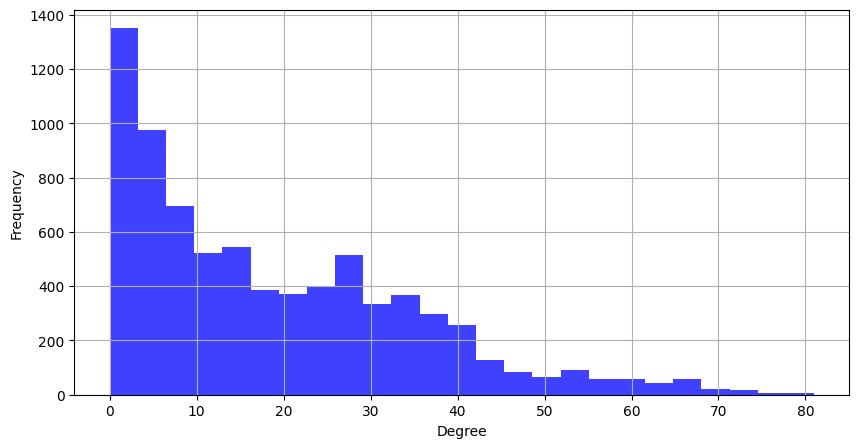

In [21]:
degrees = adj_matrix.coalesce().indices().numpy()[0]  #A
degree_count = np.bincount(degrees, minlength=num_nodes)

plt.figure(figsize=(10, 5))
plt.hist(degree_count, bins=25, alpha=0.75, color='blue')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Graph Autoencoder

In [24]:
from torch_geometric.nn import GCNConv    #A

class GCNEncoder(torch.nn.Module):    #B
    def __init__(self, input_size, layers, latent_dim):    #B
        super().__init__()
        self.conv0 = GCNConv(input_size, layers[0])    #C
        self.conv1 = GCNConv(layers[0], layers[1])    #C
        self.conv2 = GCNConv(layers[1], latent_dim)    #C

    def forward(self, x, edge_index):    #D
        x = self.conv0(x, edge_index).relu()    #D
        x = self.conv1(x, edge_index).relu()    #D
        return self.conv2(x, edge_index)    #D


In [25]:
class InnerProductDecoder(torch.nn.Module):    #A
    def __init__(self):    #A
         super().__init__()    #A

    def forward(self, z, edge_index):    #B
      value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)    #C
      return torch.sigmoid(value)

In [26]:
class GraphAutoEncoder(torch.nn.Module):
    def __init__(self, input_size, layers, latent_dims):
      super().__init__()
      self.encoder = GCNEncoder(input_size, layers, latent_dims)    #A
      self.decoder = InnerProductDecoder()    #B

    def forward(self, x):
      z = self.encoder(x)
      return self.decoder(z)

In [27]:

# Old snippet
# from torch_sparse import SparseTensor #A

# edge_index = adj_matrix.nonzero(as_tuple=False).t() #B

# adj = SparseTensor(row=edge_index[0], #C
#                  col=edge_index[1], #C
#                  sparse_sizes=(num_nodes, num_nodes)) #C

# New snippet
from torch_geometric.utils import to_edge_index

# Convert adj_matrix to edge_index and edge_attr
edge_index, edge_attr = to_edge_index(adj_matrix) #A
num_nodes = adj_matrix.size(0)

In [28]:
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit, RandomLinkSplit
import torch_geometric.transforms as T

#Old snippet
# data = Data(x=feature_matrix, y=labels, adj_t=adj) #A
# transform = T.Compose([
# 	T.NormalizeFeatures(),#B
# 	T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,#B
#                   	add_negative_train_samples=False)]) #B
# train_data, val_data, test_data = transform(data)

#New snippet

data = Data(x=feature_matrix,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

In [29]:
train_data.is_cuda

True

In [30]:
# # old snippet
# input_size, latent_dims = num_features, 16 #A
# layers = [512, 256] #A
# model = GraphAutoEncoder(input_size, layers, latent_dims) #B
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss() #C

# new snippet

num_features = feature_matrix.shape[1]

input_size, latent_dims = num_features, 16 #A
layers = [512, 256] #A
model = GraphAutoEncoder(input_size, layers, latent_dims) #B

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss() #C


In [31]:
from torch_geometric.utils import negative_sampling

def train(model, criterion, optimizer):

    model.train()

    optimizer.zero_grad()
    z = model.encoder(train_data.x, train_data.edge_index) #A

    neg_edge_index = negative_sampling( #B
    edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,#B
    num_neg_samples=train_data.edge_label_index.size(1), method='sparse')#B

    edge_label_index = torch.cat( #C
    [train_data.edge_label_index, neg_edge_index], #C
    dim=-1,) #C

    out = model.decoder(z, edge_label_index).view(-1) #D

    edge_label = torch.cat([ #E
    train_data.edge_label,#E
    train_data.edge_label.new_zeros(neg_edge_index.size(1))#E
    ], dim=0)#E

    loss = criterion(out, edge_label) #F
    loss.backward() #F
    optimizer.step()

    return loss


In [32]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encoder(data.x, data.edge_index) #A
    out = model.decoder(z, data.edge_label_index).view(-1).sigmoid() #B
    loss = roc_auc_score(data.edge_label.cpu().numpy(),#C
                        out.cpu().numpy()) #C
    return loss


In [33]:
#old snippet

# best_val_auc = final_test_auc = 0
# for epoch in range(1, 201):
#     loss = train(model, criterion, optimizer) #A
#     val_auc = test(val_data) #B
#     if val_auc > best_val_auc:
#         best_val_auc = val_auc
# test_auc = test(test_data) #C

# new snippet

from tqdm.notebook import tqdm

best_val_auc = final_test_auc = 0
pbar = tqdm(range(200), desc="Training")
for epoch in pbar:
    loss = train(model, criterion, optimizer)
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc

    # Update progress bar description
    pbar.set_description(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Test AUC: {test_auc:.4f}")

print(f'Final Test: {final_test_auc:.4f}')

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Final Test: 0.8644


## Variational Graph Autoencoder

In [34]:
from torch_geometric.nn import GCNConv    #A

class VariationalGCNEncoder(torch.nn.Module): #A
    def __init__(self, input_size, layers, latent_dims):
        super().__init__()
        self.layer0 = GCNConv(input_size, layers[0])
        self.layer1 = GCNConv(layers[0], layers[1])
        self.layer2 = GCNConv(layers[1], 2*latent_dims)
        self.conv_mu = GCNConv(2 * latent_dims, latent_dims) #A
        self.conv_logvar = GCNConv(2 * latent_dims, latent_dims)#A

    def forward(self, x, edge_index):
        x = self.layer0(x, edge_index).relu()
        x = self.layer1(x, edge_index).relu()
        x = self.layer2(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index) #B


class VariationalGCNEncoder(torch.nn.Module): #A
  def __init__(self, input_size, layers, latent_dims):
    super().__init__()
    self.layer0 = GCNConv(input_size, layers[0])
    self.layer1 = GCNConv(layers[0], layers[1])
    self.mu = GCNConv(layers[1], latent_dims)
    self.logvar = GCNConv(layers[1], latent_dims)

  def forward(self, x, edge_index):
    x = self.layer0(x, edge_index).relu()
    x = self.layer1(x, edge_index).relu()
    mu = self.mu(x, edge_index)
    logvar = self.logvar(x, edge_index)
    return mu, logvar

In [35]:
from torch_geometric.nn import VGAE #A
model = VGAE(VariationalGCNEncoder(input_size, layers, latent_dims)) #A
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss() #C



In [36]:
def train(model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
    edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
    num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
    [train_data.edge_label_index, neg_edge_index],
    dim=-1,)
    out = model.decode(z, edge_label_index).view(-1)

    edge_label = torch.cat([
    train_data.edge_label,
    train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    loss = criterion(out, edge_label) + (1 / train_data.num_nodes) * model.kl_loss() #A

    loss.backward()
    optimizer.step()

    return loss



In [37]:

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index) #A
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid() #B
    loss = roc_auc_score(data.edge_label.cpu().numpy(),#C
                        out.cpu().numpy()) #C
    return loss


In [38]:
from tqdm.notebook import tqdm

best_val_auc = final_test_auc = 0
pbar = tqdm(range(200), desc="Training")
for epoch in pbar:
    loss = train(model, criterion, optimizer)
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc

    # Update progress bar description
    pbar.set_description(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Test AUC: {test_auc:.4f}")

print(f'Final Test: {final_test_auc:.4f}')

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Final Test: 0.8709


In [39]:
train_data.edge_index

tensor([[2339,  731, 3063,  ..., 7373, 2415, 5772],
        [5881, 5070, 3844,  ..., 7072,  756, 2332]], device='cuda:0')